In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-x2ir6n08
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-x2ir6n08
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264356 sha256=8d2c19dd43a05d4282a32ea3a890f855d2faec7add367ff61fa698a13a0d1eba
  Stored in directory: /tmp/pip-ephem-wheel-cache-rejsofg8/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 116818, done.
remote: Counting objects: 100% (9498/9498), done.
remote: Compressing objects: 100% (851/851), done.
remote: Total 116818 (delta 8716), reused 9301 (delta 8599), pack-reused 107320
Receiving objects: 100% (116818/116818), 229.19 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (101379/101379), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
import json
from pathlib import Path
from typing import List, Union, Tuple, NamedTuple, Dict

import torch
import torchvision
import torchvision.models as zoo

from PIL import Image

## Dataset

In [ ]:
class LabelMeDataset(torch.utils.data.Dataset):

    def __init__(self,
                 image_paths: List[Union[str, Path]],
                 annotation_paths: List[Union[str, Path]],
                 classes = List[str],
                 transforms = None):

        super().__init__()
        if len(image_paths) != len(annotation_paths):
            raise ValueError("Image files and annotations files must have the same lenght.")

        self.classes = classes
        self.label2idx = {c: i for i, c in enumerate(self.classes, start=1)}
        
        self.images_paths = [Path(o) for o in image_paths]
        self.annotation_paths = [Path(o) for o in annotation_paths]
        
        self.transforms = transforms

    def _read_annot(self, idx: int) -> Tuple[Image.Image, List[Tuple[str, List[float]]]]:
        def shape_to_instance(shape):
            points = sum(shape['points'], [])
            return shape['label'], points

        with self.annotation_paths[idx].open() as f:
            annot_data = json.load(f)
        
        # Load the image
        image_path = self.images_paths[idx]
        im = Image.open(image_path)
        
        # Load detection instances
        shapes = annot_data['shapes']
        instances = [shape_to_instance(s) for s in shapes]

        return im, instances

    def __getitem__(self, idx: Union[int, torch.LongTensor]):
        if isinstance(idx, torch.LongTensor):
            idx = idx.item()

        im, boxes = self._read_annot(idx)
        labels, bbs = zip(*boxes)
        
        bbs = torch.as_tensor(bbs).float()
        labels = torch.as_tensor([self.label2idx[l] for l in labels]).long()
        
        target = {
            "boxes": bbs, 
            "labels": labels, 
            "image_id": torch.as_tensor(idx),
            "area": (bbs[:, 2] - bbs[:, 0]) * (bbs[:, 3] - bbs[:, 1]),
            "iscrowd": torch.zeros((bbs.size(0),), dtype=torch.long) 
          }

        if self.transforms is not None:
            im, target = self.transforms(im, target)
        
        return im, target

    def __len__(self) -> int:
        return len(self.annotation_paths)

In [ ]:
def draw_boxes(im: Union[Image.Image, torch.Tensor], targets: Dict[str, torch.Tensor]) -> Image.Image:
  if not torch.is_tensor(im):
    im = (torchvision.transforms.functional.to_tensor(im) * 255).byte()

  bbs = targets["boxes"]
  return torchvision.transforms.functional.to_pil_image(
      torchvision.utils.draw_bounding_boxes(image=im, 
                                            boxes=bbs, 
                                            width=3, 
                                            colors=[(0, 255, 0)] * bbs.size(0)))

In [ ]:
!cp "drive/My Drive/datasets/optc.zip" .
!unzip -q optc.zip

In [ ]:
import itertools

def list_labeled_files(base_path):
  base_path = Path(base_path)
  images = list(itertools.chain(base_path.rglob("*.png"), base_path.rglob("*.jpg"), base_path.rglob("*.jpeg")))
  annotations = [im_path.parent / f"{im_path.stem}.json" for im_path in images]
  filtered_images = []
  filtered_annotations = []

  for a, im in zip(annotations, images):
    if a.exists():
      filtered_images.append(im)
      filtered_annotations.append(a)

  return filtered_images, filtered_annotations

character_box_samples = list_labeled_files("screenshots/character-box")
syn_samples = list_labeled_files("syn")


ds = LabelMeDataset(image_paths=character_box_samples[0] + syn_samples[0], 
                    annotation_paths=character_box_samples[1] + syn_samples[1], 
                    classes=["character"])


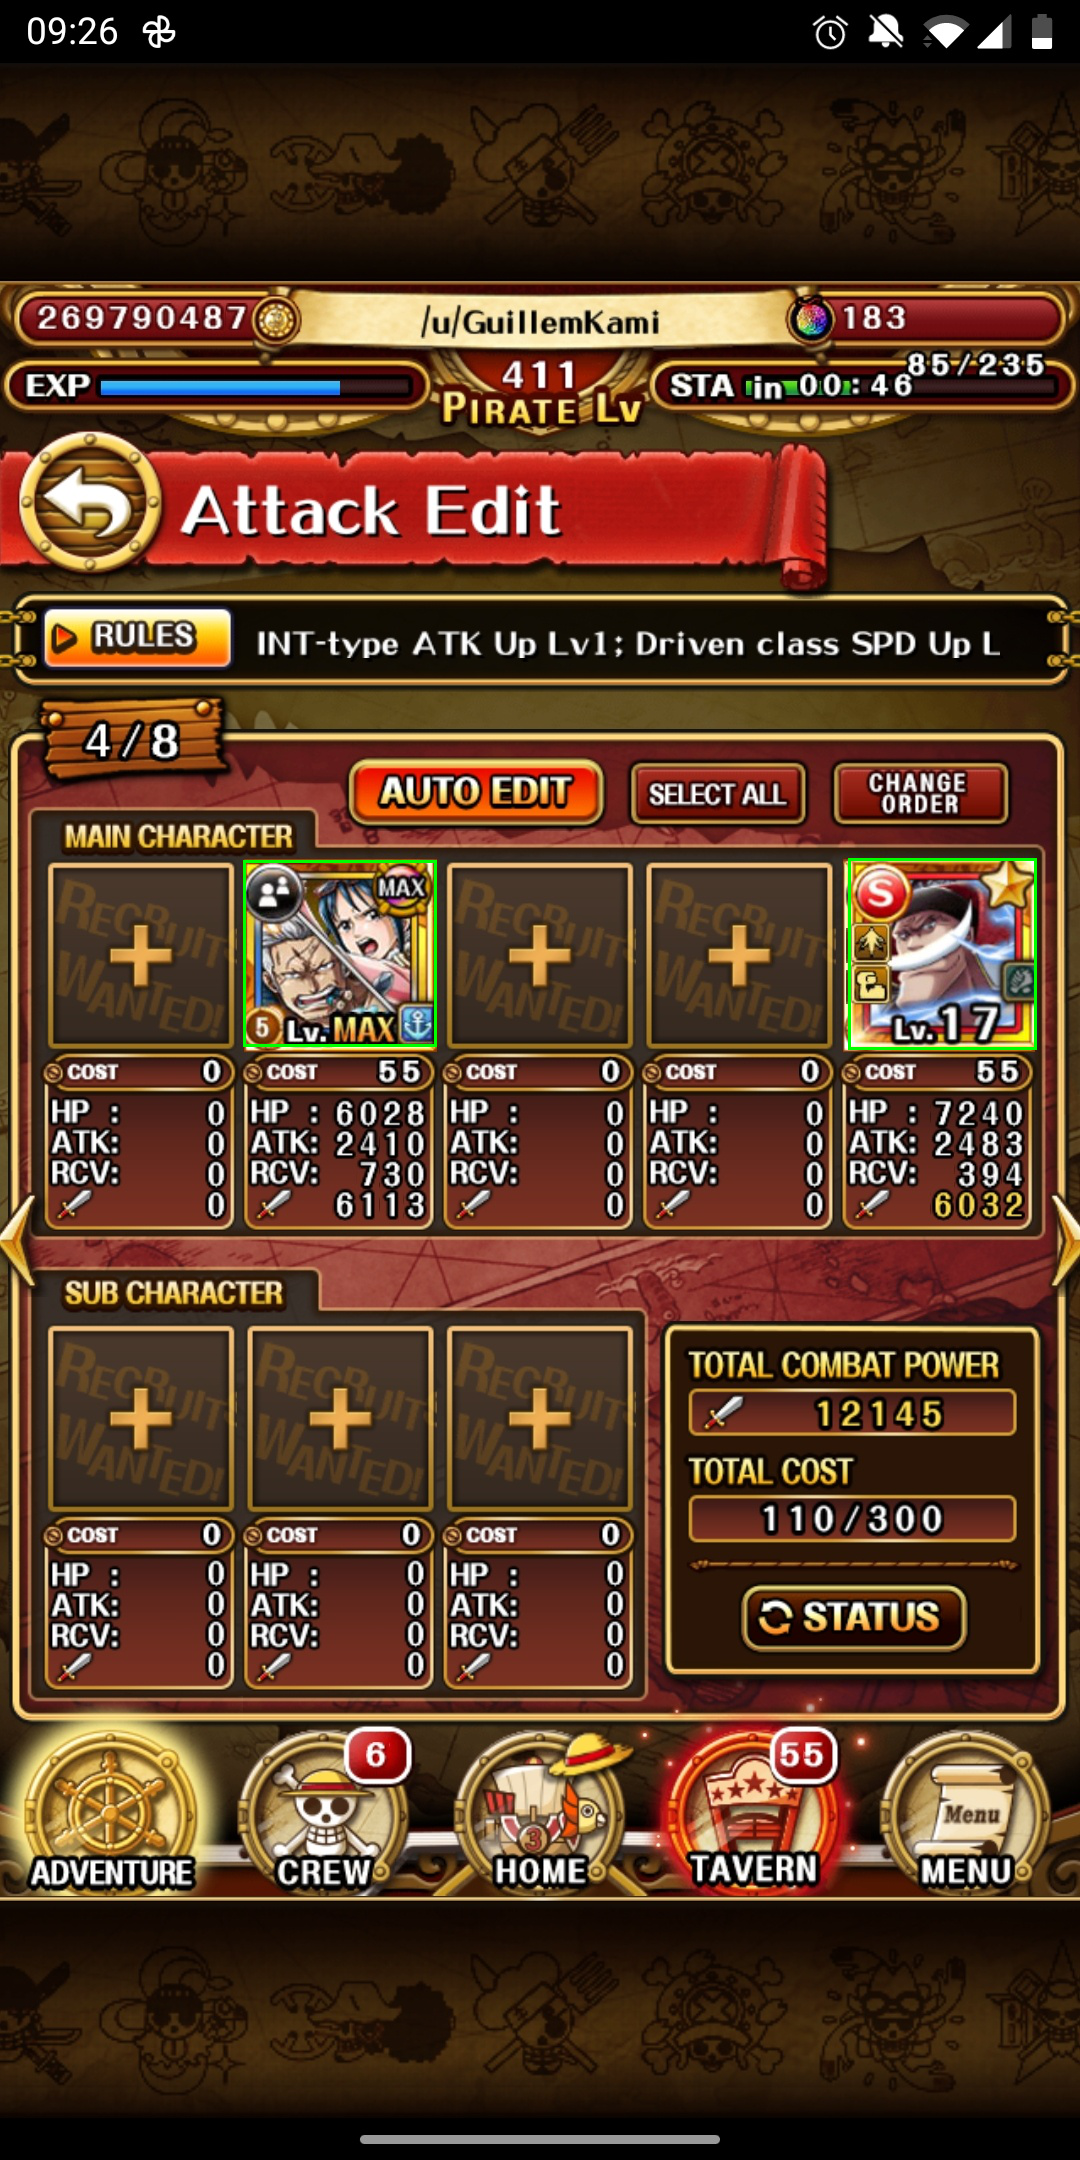

In [ ]:
import random
idx = random.randint(0, len(ds))
draw_boxes(*ds[idx])

## Define model

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
num_classes = 2 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = zoo.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


## Train model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
train_ds = LabelMeDataset(image_paths=character_box_samples[0] + syn_samples[0], 
                    annotation_paths=character_box_samples[1] + syn_samples[1], 
                    classes=["character"],
                    transforms=get_transform(True))

test_ds = LabelMeDataset(image_paths=character_box_samples[0] + syn_samples[0], 
                    annotation_paths=character_box_samples[1] + syn_samples[1], 
                    classes=["character"],
                    transforms=get_transform(False))


rand_idx = torch.randperm(len(ds))
train_idx = rand_idx[:int(len(ds) * .9)]
test_idx = rand_idx[int(len(ds) * .9):]

train_ds = torch.utils.data.Subset(train_ds, train_idx.tolist())
test_ds = torch.utils.data.Subset(test_ds, test_idx.tolist())

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)

test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.zero_grad()
model.train()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_dl, device=device)

Epoch: [0]  [  0/590]  eta: 0:12:18  lr: 0.000013  loss: 1.6394 (1.6394)  loss_classifier: 0.6113 (0.6113)  loss_box_reg: 0.8447 (0.8447)  loss_objectness: 0.1587 (0.1587)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 1.2512  data: 0.8549  max mem: 1277
Epoch: [0]  [ 50/590]  eta: 0:03:07  lr: 0.000438  loss: 1.0321 (1.2487)  loss_classifier: 0.3662 (0.4509)  loss_box_reg: 0.6254 (0.7124)  loss_objectness: 0.0254 (0.0720)  loss_rpn_box_reg: 0.0094 (0.0134)  time: 0.3206  data: 0.0252  max mem: 1360
Epoch: [0]  [100/590]  eta: 0:02:43  lr: 0.000862  loss: 0.4807 (0.9093)  loss_classifier: 0.1968 (0.3420)  loss_box_reg: 0.2715 (0.5133)  loss_objectness: 0.0092 (0.0427)  loss_rpn_box_reg: 0.0082 (0.0113)  time: 0.3249  data: 0.0268  max mem: 1545
Epoch: [0]  [150/590]  eta: 0:02:24  lr: 0.001286  loss: 0.4417 (0.7598)  loss_classifier: 0.1648 (0.2906)  loss_box_reg: 0.2588 (0.4247)  loss_objectness: 0.0041 (0.0316)  loss_rpn_box_reg: 0.0056 (0.0129)  time: 0.3000  data: 0.0238  max mem: 1545


KeyboardInterrupt: ignored

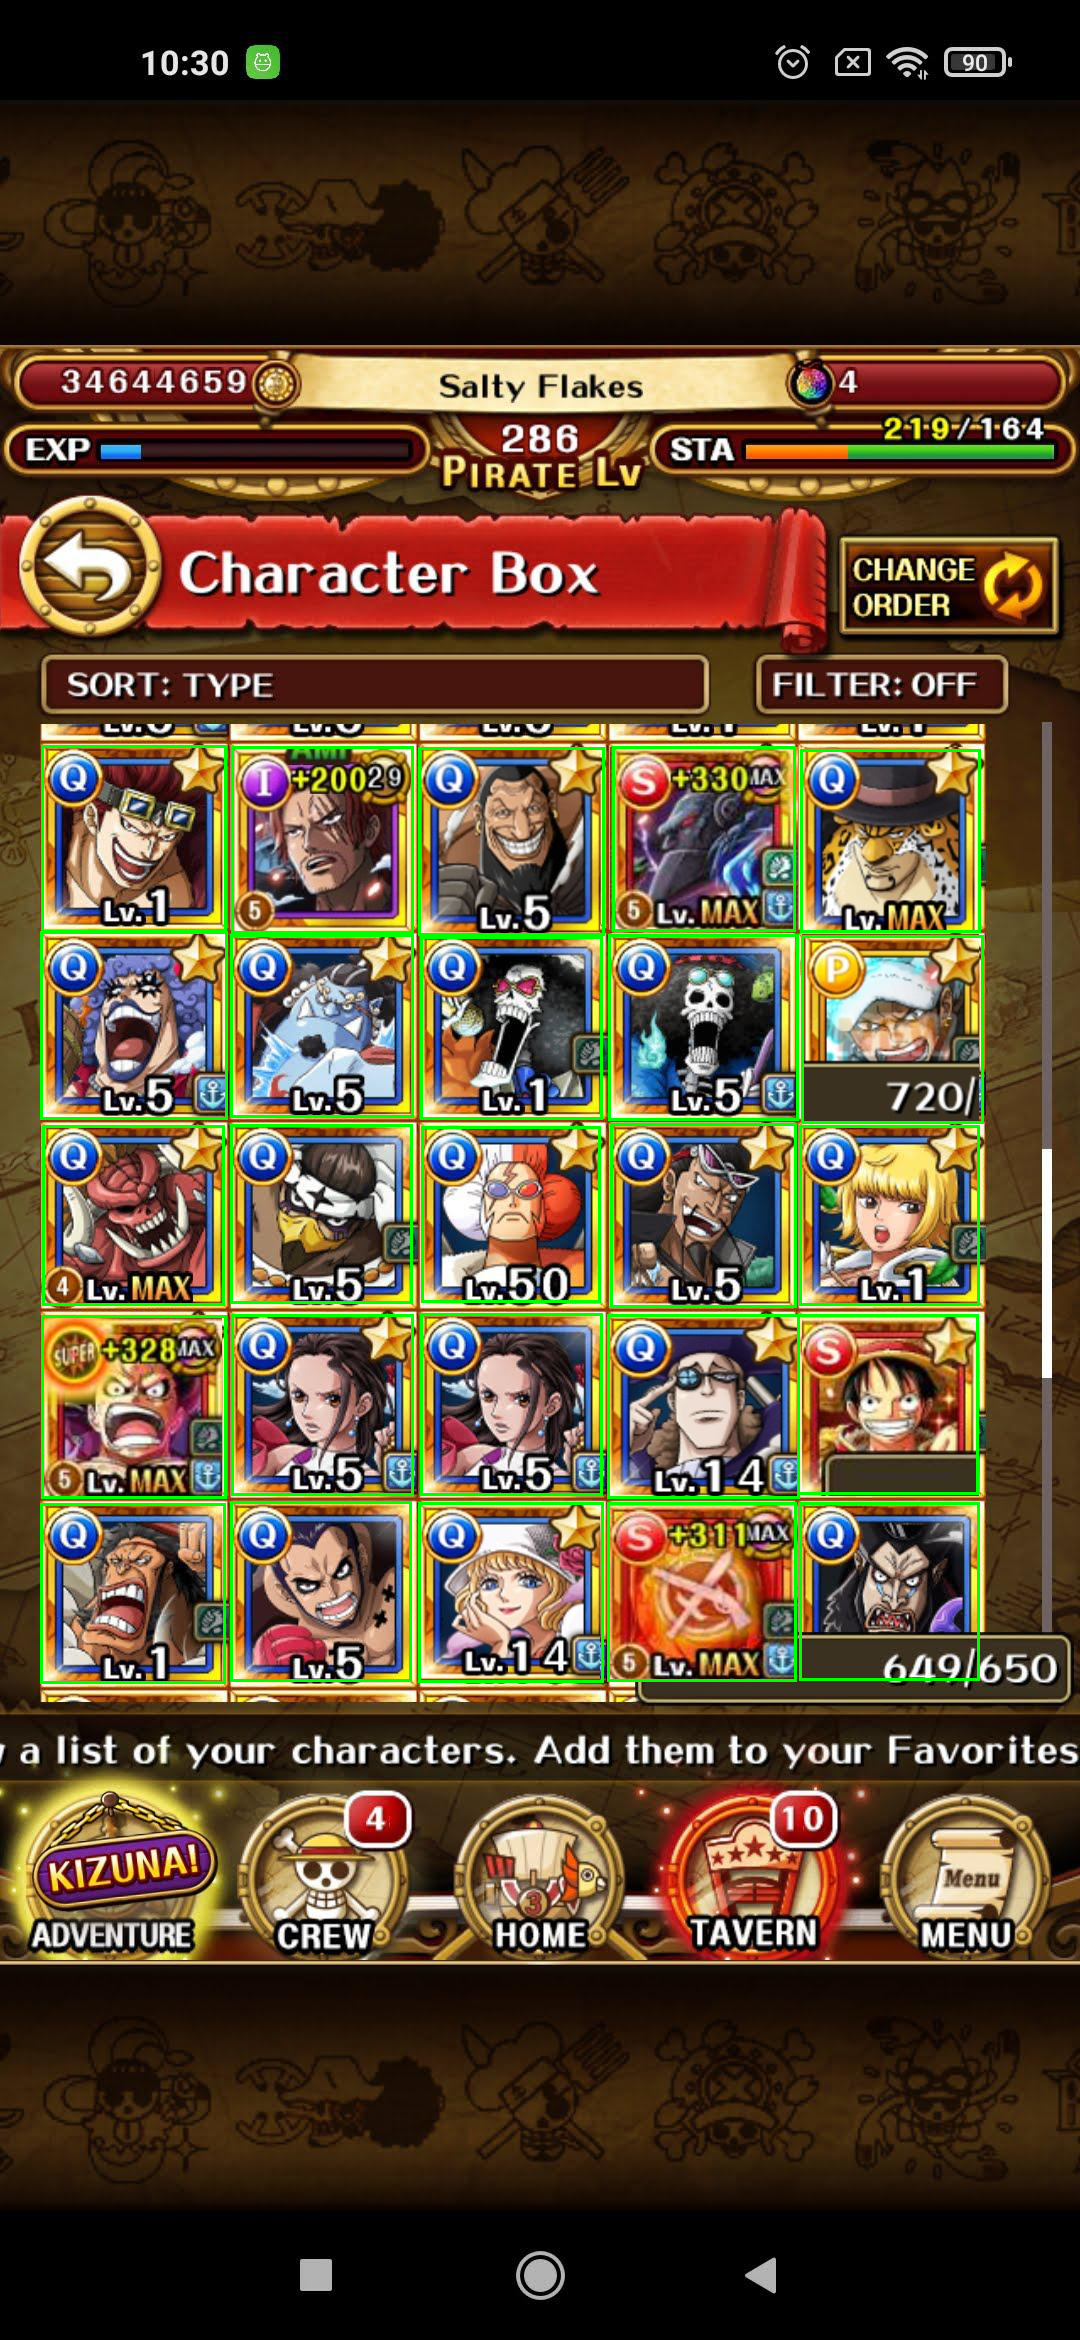

In [ ]:
# pick one image from the test set
import random

img, _ = test_ds[random.randint(0, len(test_ds))]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    prediction["boxes"] = prediction["boxes"][prediction["scores"] > .8]
draw_boxes(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), prediction)